# Test Plots

## Init

In [ ]:
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from skimage.transform import rescale
from skimage.filters import gaussian
import tifffile
from fractions import Fraction

from ridge_extractor import extract_ridge_from_image, find_features
from ridge_models import style_exact, style_ld_ts, shanahan, limat_symmetric
from data_types import RidgeFit, RidgeFitMethod
from ridge_profile_fit import fit_profile
from skimage.draw import circle_perimeter

initial_params_actual = {\
    "h" : {"thick": 0.001, "thin": 0.0002},
    "E_lookup" : {"70_S":4863
,"70_H":8914,"80_S":1824,"80_H":13679},
    "E_lookup_max" : {"70_S":2428+66,"70_H":8914+601,"80_S":1824+57,"80_H":13679+811},
    "E_lookup_min" : {"70_S":2428-66,"70_H":8914-601,"80_S":1824-57,"80_H":13679-811},
    "upsilon" : (0.059+0.016)/2, # from Park et al
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
    "gamma_s": 0.021, # https://doi.org/10.1038/ncomms5369, https://doi.org/10.1103/PhysRevLett.109.038001
    "theta": 100
}

source_dir = Path(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge")
source_dir_evap = Path(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_evap")

chosen_measurments = ["70vs80_evap/70_S_1_thick_evap_f/70_S_1_thick_evap_f.ome.pkl", "70vs80/70_H_1_thick_f/70_H_1_thick_f.ome.pkl", 
                      "70vs80_evap/80_S_1_thick_evap_f/80_S_1_thick_evap_f.ome.pkl", "70vs80/80_H_1_thick_f/80_H_1_thick_f.ome.pkl"]
sources = [source_dir / meas for meas in chosen_measurments]

## 3D plot simple

In [ ]:
# glb = source_dir.parent.rglob("70vs80*/**/*thick*.pkl")
# glb = [(source_dir / meas).with_suffix(".pkl") for meas in chosen_measurments]
target_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\plots")
for file in sources:
    if "_test" in str(file) or "_first" in str(file) or "_second" in str(file):
        continue
    try:
        
        with open(file, "rb") as f:
            yc,xc,r,r2,image,pixelscale,rim_binarized,img_calc,downscale_factor,fits,ridge,radial_coord,x_grid,y_grid = pickle.load(f)

        image = gaussian(image, sigma=20)
        x_grid *= 1000
        y_grid *= 1000
        image *= 1000

        fig = plt.figure(figsize=(20, 4))
        ax = fig.add_subplot(1, 1, 1, projection="3d")
        ax.plot_surface(x_grid, y_grid, image, cmap="seismic")
        ax.set_ylim(ax.get_xlim())
        ax.set_zlim(-0.1,0.1)
        fig.suptitle(file.stem)
        plt.tight_layout()
        plt.show()
        fig.savefig(target_dir / (file.stem + "_3d.pdf"), bbox_inches="tight")
    except:
        pass

## 3D plot plotly

In [ ]:
import plotly
import plotly.graph_objects as go
# plotly.offline.init_notebook_mode()

# glb = source_dir.parent.rglob("70vs80*/**/*.pkl")
target_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\plots")
for file in sources:
    if "_test" in str(file) or "_first" in str(file) or "_second" in str(file):
        continue
    try:
        
        with open(file, "rb") as f:
            yc,xc,r,r2,image,pixelscale,rim_binarized,img_calc,downscale_factor,fits,ridge,radial_coord,x_grid,y_grid = pickle.load(f)

        image = gaussian(image, sigma=20)
        x_grid *= 1000
        y_grid *= 1000
        image *= 1000

        
        image = rescale(image, downscale_factor, anti_aliasing=True)
        x_grid = rescale(x_grid, downscale_factor)
        y_grid = rescale(y_grid, downscale_factor)

        fig = go.Figure(data=[go.Surface(z=image, x=x_grid[0,:], y=y_grid[:,0], colorscale="rdbu_r", cmin=-0.01, cmax=0.01, showscale=False)])

        fig.update_layout(title=file.stem, autosize=False,
                          width=800, height=800,
                          margin=dict(l=65, r=50, b=65, t=90))
        
        fig.show()
        fig.write_html(str(target_dir / (file.stem + "_3d.html")))
        # plotly.offline.iplot(fig)
        # plotly.io.write_image(fig, str(target_dir / (file.stem + "_3d.html")))
    except Exception as e:
        print(e)

    # break

## 3d plot all data

In [ ]:

# glb = source_dir.parent.rglob("70vs80*/**/*.pkl")


initial_params = {\
    "h" : {"thick": 0.001, "thin": 0.0002},
    "E_lookup" : {"70_S":1500,"70_H":3000,"80_S":4500,"80_H":10500},
    "upsilon" : (0.059+0.019)/2, # from https://doi.org/10.1002/marc.202000360, https://doi.org/10.1038/ncomms5369, https://iopscience.iop.org/article/10.1088/0370-1298/63/5/302/pdf
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
    "gamma_s": 0.021, # https://doi.org/10.1038/ncomms5369, https://doi.org/10.1103/PhysRevLett.109.038001
    "theta": 100
}
for file in sources:
    try:
        if "_test" in str(file) or "_first" in str(file) or "_second" in str(file):
            continue

        with open(file, "rb") as f:
            yc,xc,r,r2,image,pixelscale,rim_binarized,img_calc,downscale_factor,fits,ridge,radial_coord,x_grid,y_grid = pickle.load(f)
        cy, cx = circle_perimeter(yc,xc,r)

        x_g_d = rescale(x_grid,downscale_factor)
        y_g_d = rescale(y_grid,downscale_factor)
        image = gaussian(image, sigma=20)

        # point_sel = np.where(x_grid>0)
        # x_grid = x_grid[image.shape[0]//2:,:]
        # y_grid = y_grid[image.shape[0]//2:,:]
        # image = image[image.shape[0]//2:,:]

        # point_sel_down = np.where(x_g_d>0)
        # x_g_d = x_g_d[img_expect.shape[0]//2:,:]
        # y_g_d = y_g_d[img_expect.shape[0]//2:,:]
        # img_expect = img_expect[img_expect.shape[0]//2:,:]
        # img_calc = img_calc[img_calc.shape[0]//2:,:]
        
        fig = plt.figure(figsize=(20, 4))
        # fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, nrows=1, figsize=(20, 4))
        fig.suptitle(f"{fits["style"].iron_content}_{fits["style"].shear_mod}_{fits["style"].volume}"
                    f"- {fits["style"].radius*1000:.1f}mm - {file.stem.split('_')[-2]} - $\\theta_S$ {fits["style"].peak_angle:.1f}")
        ax1 = fig.add_subplot(151, projection='3d')
        ax1.set_title('Original picture')
        # ax1.imshow(image)
        # ax1.plot(cx,cy, "r,")
        ax1.plot_surface(x_grid, y_grid, image, cmap="seismic")
        ax1.set_ylim(ax1.get_xlim())
        ax1.set_zlim(-1e-4,1e-4)
        # ax1.set_ylim(top=0)

        # ax2= fig.add_subplot(152, projection='3d')

        # ax2.set_title('Expected Shape')
        # # ax2.imshow(img_expect)
        # ax2.plot_surface(x_g_d, y_g_d, img_expect, cmap="viridis")
        # # ax2.set_ylim(top=0)
        # ax2.set_zlim(ax1.get_zlim())
        # ax2.set_ylim(ax1.get_xlim())
        # ax2.shareview(ax1)

        ax3= fig.add_subplot(152, projection='3d')

        ax3.set_title('Fit Shape')
        ax3.plot_surface(x_g_d, y_g_d, img_calc, cmap="seismic")
        # ax3.set_ylim(top=0)
        ax3.set_zlim(ax1.get_zlim())
        ax3.set_ylim(ax1.get_xlim())
        ax3.shareview(ax1)
        # ax3.imshow(img_calc)


        # ax4= fig.add_subplot(154)

        # ax4.set_title('Diff: Actual - Style Fit')
        # ax4.imshow(rescale(image, downscale_factor, anti_aliasing=False) - img_calc)

        ax4= fig.add_subplot(153)
        
        ax4.set_title('Extracted Ridge')
        ax4.plot(ridge[0], ridge[1], "k.")
        fit_x = np.linspace(fits["style"].x_values.min(), fits["style"].x_values.max(), 250)

        def _fit_helper(fits, model, x, ax):
            styles_dict={"style":"b-","style_ld":"r-","shanahan":"m-","limat":"g-"}
            label_dict={"style":"Exact","style_ld":"R>>h","shanahan":"Sha","limat":"Lim"}
            fitfunc_dict={"style":style_exact,"style_ld":style_ld_ts,"shanahan":shanahan,"limat":limat_symmetric}
            rf = fits[model]
            ax.plot(x, fitfunc_dict[model](x, rf.gamma, rf.radius, *rf.popt), styles_dict[model], label=label_dict[model])
        rf = fits["style"]
        
        for model in fits.keys():
            if model == "actual": continue
            _fit_helper(fits, model, fit_x, ax4)

        ax5= fig.add_subplot(154)

        ax5.set_title('Fit vs Expected')
        # ax5.plot(ridge[0], ridge[1], "k.")
        # fit_x = np.linspace(fits["style"].x_values.min(), fits["style"].x_values.max(), 250)
        Fe, G, vol, th, *_ = Path(file).stem.split("_")
        def _fit_helper(fits, model, ax):
            styles_dict={"style":"b-","style_ld":"r-","shanahan":"m-","limat":"g-"}#
            styles_dict2={"style":"b--","style_ld":"r--","shanahan":"m-","limat":"g-"}
            label_dict={"style":"Exact","style_ld":"R>>h","shanahan":"Sha","limat":"Lim"}
            fitfunc_dict={"style":style_exact,"style_ld":style_ld_ts,"shanahan":shanahan,"limat":limat_symmetric}
            rf = fits[model]
            x = np.linspace(-rf.radius*1.5, rf.radius*1.5, 500)
            ax.plot(x, fitfunc_dict[model](x, rf.gamma, rf.radius, *rf.popt), styles_dict[model], label=label_dict[model])
            ax.plot(x, fitfunc_dict[model](x, rf.gamma, rf.radius, rf.popt[0], initial_params_actual["E_lookup"][f"{Fe}_{G}"], initial_params_actual["h"][th]), styles_dict2[model], label=label_dict[model])
        rf = fits["style"]
        
        for model in fits.keys():
            if model in ["actual","shanahan","limat"]: continue
            _fit_helper(fits, model, ax5)
        ax5.set_ylim(ax4.get_ylim())
        
        #print model params of style and style_ld
        names = ("ups", "E", "h")
        style_printable = [f"{name}: {fits["style"].popt[i]:.5g}" for i, name in enumerate(names)]
        style_ld_printable = [f"{name}: {fits["style_ld"].popt[i]:.5g}" for i, name in enumerate(names)]
        print(f"{file.stem} - Style: {style_printable} (R2: {fits["style"].r2:.3f}) - Style_LD: {style_ld_printable}(R2: {fits["style_ld"].r2:.3f})")

        plt.legend()
        plt.show()
        target_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\plots")
        fig.savefig(target_dir / ("ridge_" + file.stem + ".pdf"), bbox_inches="tight")
    except:
        pass

## 3d Plot only 80_S-1

In [ ]:

# glb = source_dir.parent.rglob("70vs80*/**/*80_S_1*.pkl")


initial_params = {\
    "h" : {"thick": 0.001, "thin": 0.0002},
    "E_lookup" : {"70_S":1500,"70_H":3000,"80_S":4500,"80_H":10500},
    "upsilon" : (0.059+0.019)/2, # from https://doi.org/10.1002/marc.202000360, https://doi.org/10.1038/ncomms5369, https://iopscience.iop.org/article/10.1088/0370-1298/63/5/302/pdf
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
    "gamma_s": 0.021, # https://doi.org/10.1038/ncomms5369, https://doi.org/10.1103/PhysRevLett.109.038001
    "theta": 100
}
for file in sources:
    try:
        if "_test" in str(file) or "_first" in str(file) or "_second" in str(file):
            continue

        with open(file, "rb") as f:
            yc,xc,r,r2,image,pixelscale,rim_binarized,img_calc,downscale_factor,fits,ridge,radial_coord,x_grid,y_grid = pickle.load(f)
        cy, cx = circle_perimeter(yc,xc,r)

        x_g_d = rescale(x_grid,downscale_factor)
        y_g_d = rescale(y_grid,downscale_factor)
        image = gaussian(image, sigma=20)

        # point_sel = np.where(x_grid>0)
        # x_grid = x_grid[image.shape[0]//2:,:]
        # y_grid = y_grid[image.shape[0]//2:,:]
        # image = image[image.shape[0]//2:,:]

        # point_sel_down = np.where(x_g_d>0)
        # x_g_d = x_g_d[img_expect.shape[0]//2:,:]
        # y_g_d = y_g_d[img_expect.shape[0]//2:,:]
        # img_expect = img_expect[img_expect.shape[0]//2:,:]
        # img_calc = img_calc[img_calc.shape[0]//2:,:]
        
        fig = plt.figure(figsize=(20, 4))
        # fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, nrows=1, figsize=(20, 4))

        ax1 = fig.add_subplot(151, projection='3d')
        ax1.set_title('Original picture')
        # ax1.imshow(image)
        # ax1.plot(cx,cy, "r,")
        ax1.plot_surface(x_grid, y_grid, image, cmap="seismic")
        ax1.set_ylim(ax1.get_xlim())
        ax1.set_zlim(-1e-4,1e-4)
        # ax1.set_ylim(top=0)

        # ax2= fig.add_subplot(152, projection='3d')

        # ax2.set_title('Expected Shape')
        # # ax2.imshow(img_expect)
        # ax2.plot_surface(x_g_d, y_g_d, img_expect, cmap="viridis")
        # # ax2.set_ylim(top=0)
        # ax2.set_zlim(ax1.get_zlim())
        # ax2.set_ylim(ax1.get_xlim())
        # ax2.shareview(ax1)

        ax3= fig.add_subplot(152, projection='3d')

        ax3.set_title('Fit Shape')
        ax3.plot_surface(x_g_d, y_g_d, img_calc, cmap="seismic")
        # ax3.set_ylim(top=0)
        ax3.set_zlim(ax1.get_zlim())
        ax3.set_ylim(ax1.get_xlim())
        ax3.shareview(ax1)
        # ax3.imshow(img_calc)


        # ax4= fig.add_subplot(154)

        # ax4.set_title('Diff: Actual - Style Fit')
        # ax4.imshow(rescale(image, downscale_factor, anti_aliasing=False) - img_calc)

        ax4= fig.add_subplot(153)
        
        ax4.set_title('Extracted Ridge')
        ax4.plot(ridge[0], ridge[1], "k.")
        fit_x = np.linspace(fits["style"].x_values.min(), fits["style"].x_values.max(), 250)

        def _fit_helper(fits, model, x, ax):
            styles_dict={"style":"b-","style_ld":"r-","shanahan":"m-","limat":"g-"}
            label_dict={"style":"Exact","style_ld":"R>>h","shanahan":"Sha","limat":"Lim"}
            fitfunc_dict={"style":style_exact,"style_ld":style_ld_ts,"shanahan":shanahan,"limat":limat_symmetric}
            rf = fits[model]
            ax.plot(x, fitfunc_dict[model](x, rf.gamma, rf.radius, *rf.popt), styles_dict[model], label=label_dict[model])
        rf = fits["style"]
        
        for model in fits.keys():
            if model in ["actual","shanahan","limat"]: continue
            _fit_helper(fits, model, fit_x, ax4)

        # ax5= fig.add_subplot(154)

        # ax5.set_title('Fit vs Expected')
        # # ax5.plot(ridge[0], ridge[1], "k.")
        # # fit_x = np.linspace(fits["style"].x_values.min(), fits["style"].x_values.max(), 250)
        # Fe, G, vol, th, *_ = Path(file).stem.split("_")
        # def _fit_helper(fits, model, ax):
        #     styles_dict={"style":"b-","style_ld":"r-","shanahan":"m-","limat":"g-"}#
        #     styles_dict2={"style":"b--","style_ld":"r--","shanahan":"m-","limat":"g-"}
        #     label_dict={"style":"Exact","style_ld":"R>>h","shanahan":"Sha","limat":"Lim"}
        #     fitfunc_dict={"style":style_exact,"style_ld":style_ld_ts,"shanahan":shanahan,"limat":limat_symmetric}
        #     rf = fits[model]
        #     x = np.linspace(-rf.radius*1.5, rf.radius*1.5, 500)
        #     ax.plot(x, fitfunc_dict[model](x, rf.gamma, rf.radius, *rf.popt), styles_dict[model], label=label_dict[model])
        #     ax.plot(x, fitfunc_dict[model](x, rf.gamma, rf.radius, rf.popt[0], initial_params_actual["E_lookup"][f"{Fe}_{G}"], initial_params_actual["h"][th]), styles_dict2[model], label=label_dict[model])
        # rf = fits["style"]
        
        # for model in fits.keys():
        #     if model in ["actual","shanahan","limat"]: continue
        #     _fit_helper(fits, model, ax5)
        # ax5.set_ylim(ax4.get_ylim())
        
        #print model params of style and style_ld
        names = ("ups", "E", "h")
        style_printable = [f"{name}: {fits["style"].popt[i]:.5g}" for i, name in enumerate(names)]
        style_ld_printable = [f"{name}: {fits["style_ld"].popt[i]:.5g}" for i, name in enumerate(names)]
        print(f"{file.stem} - Style: {style_printable} (R2: {fits["style"].r2:.3f}) - Style_LD: {style_ld_printable}(R2: {fits["style_ld"].r2:.3f})")

        # plt.suptitle(f"{fits["style"].iron_content}_{fits["style"].shear_mod}_{fits["style"].volume}"
                    # f"- {fits["style"].radius*1000:.1f}mm - {file.stem.split('_')[-2]} - $\\theta_S$ {fits["style"].peak_angle:.1f}")
        plt.tight_layout()
        plt.legend()
        plt.show()
        target_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\plots")
        fig.savefig(target_dir / ("ridge_" + file.stem + ".pdf"), bbox_inches="tight")
    except:
        pass

## Only 2D plot

In [ ]:

# glb = source_dir.parent.rglob("70vs80*/**/*thick*.pkl")

initial_params = {\
    "h" : {"thick": 0.001, "thin": 0.0002},
    "E_lookup" : {"70_S":1500,"70_H":3000,"80_S":4500,"80_H":10500},
    "upsilon" : (0.059+0.019)/2, # from https://doi.org/10.1002/marc.202000360, https://doi.org/10.1038/ncomms5369, https://iopscience.iop.org/article/10.1088/0370-1298/63/5/302/pdf
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
    "gamma_s": 0.021, # https://doi.org/10.1038/ncomms5369, https://doi.org/10.1103/PhysRevLett.109.038001
    "theta": 100
}
for file in sources:

        if "_test" in str(file) or "_first" in str(file) or "_second" in str(file):
            continue

        with open(file, "rb") as f:
            yc,xc,r,r2,image,pixelscale,rim_binarized,img_calc,downscale_factor,fits,ridge,radial_coord,x_grid,y_grid = pickle.load(f)
        cy, cx = circle_perimeter(yc,xc,r)

        x_g_d = rescale(x_grid,downscale_factor)
        y_g_d = rescale(y_grid,downscale_factor)
        image = gaussian(image, sigma=20)


        fig = plt.figure(figsize=(5, 4))


        ax4= fig.add_subplot(111)
        
        ax4.set_title('Extracted Ridge')
        ax4.plot(ridge[0], ridge[1], "k.")
        fit_x = np.linspace(fits["style"].x_values.min(), fits["style"].x_values.max(), 250)

        def _fit_helper(fits, model, x, ax):
            styles_dict={"style":"b-","style_ld":"r-","shanahan":"m-","limat":"g-"}
            label_dict={"style":"Exact","style_ld":"R>>h","shanahan":"Sha","limat":"Lim"}
            fitfunc_dict={"style":style_exact,"style_ld":style_ld_ts,"shanahan":shanahan,"limat":limat_symmetric}
            rf = fits[model]
            ax.plot(x, fitfunc_dict[model](x, rf.gamma, rf.radius, *rf.popt), styles_dict[model], label=label_dict[model])
        rf = fits["style"]
        
        for model in fits.keys():
            if model in ["actual","shanahan","limat"]: continue
            _fit_helper(fits, model, fit_x, ax4)

       
        
        #print model params of style and style_ld
        names = ("ups", "E", "h")
        style_printable = [f"{name}: {fits["style"].popt[i]:.5g}" for i, name in enumerate(names)]
        style_ld_printable = [f"{name}: {fits["style_ld"].popt[i]:.5g}" for i, name in enumerate(names)]
        print(f"{file.stem} - Style: {style_printable} (R2: {fits["style"].r2:.3f}) - Style_LD: {style_ld_printable}(R2: {fits["style_ld"].r2:.3f})")
        print(f"{round(fits["style"].popt[1]):.0f}&{round(fits["style_ld"].popt[1]):.0f}")

        # plt.suptitle(f"{fits["style"].iron_content}_{fits["style"].shear_mod}_{fits["style"].volume}"
                    # f"- {fits["style"].radius*1000:.1f}mm - {file.stem.split('_')[-2]} - $\\theta_S$ {fits["style"].peak_angle:.1f}")
        plt.tight_layout()
        plt.legend()
        plt.show()
        target_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\plots")
        fig.savefig(target_dir / (file.stem + "_2d.pdf"), bbox_inches="tight")


## only compare

In [ ]:

# glb = source_dir.parent.rglob("70vs80*/**/*thick*.pkl")

for file in sources:

    if "_test" in str(file) or "_first" in str(file) or "_second" in str(file):
        continue

    with open(file, "rb") as f:
        yc,xc,r,r2,image,pixelscale,rim_binarized,img_calc,downscale_factor,fits,ridge,radial_coord,x_grid,y_grid = pickle.load(f)
    cy, cx = circle_perimeter(yc,xc,r)

    x_g_d = rescale(x_grid,downscale_factor)
    y_g_d = rescale(y_grid,downscale_factor)
    image = gaussian(image, sigma=20)
    
    fig = plt.figure(figsize=(5, 4))


    ax5= fig.add_subplot(111)

    ax5.set_title('Fit vs Expected')
    # ax5.plot(ridge[0], ridge[1], "k.")
    # fit_x = np.linspace(fits["style"].x_values.min(), fits["style"].x_values.max(), 250)
    Fe, G, vol, th, *_ = Path(file).stem.split("_")
    def _fit_helper(fits, model, ax):
        styles_dict={"style":"b-","style_ld":"r-","shanahan":"m-","limat":"g-"}#
        styles_dict2={"style":"b--","style_ld":"r--","shanahan":"m-","limat":"g-"}
        label_dict={"style":"General Fit","style_ld":"R>>h Fit"}
        label_dict2={"style":"General Meas","style_ld":"R>>h Meas"}
        
        fitfunc_dict={"style":style_exact,"style_ld":style_ld_ts,"shanahan":shanahan,"limat":limat_symmetric}
        rf = fits[model]
        x1 = np.linspace(-rf.radius*1.5, 0, 500)
        x2 = np.linspace(0, rf.radius*1.5, 500)
        x_dict = {"style":x1, "style_ld":x2}
        ax.plot(x_dict[model], fitfunc_dict[model](x_dict[model], rf.gamma, rf.radius, *rf.popt), styles_dict[model], label=label_dict[model])
        ax.plot(x_dict[model], fitfunc_dict[model](x_dict[model], rf.gamma, rf.radius, rf.popt[0], initial_params_actual["E_lookup"][f"{Fe}_{G}"], initial_params_actual["h"][th]), styles_dict2[model], label=label_dict2[model])
        ax.fill_between(x_dict[model], fitfunc_dict[model](x_dict[model], rf.gamma, rf.radius, rf.popt[0], initial_params_actual["E_lookup_max"][f"{Fe}_{G}"], initial_params_actual["h"][th]), 
                        fitfunc_dict[model](x_dict[model], rf.gamma, rf.radius, rf.popt[0], initial_params_actual["E_lookup_min"][f"{Fe}_{G}"], initial_params_actual["h"][th]), 
                        alpha=0.2, color="r")
    rf = fits["style"]
    
    for model in fits.keys():
        if model in ["actual","shanahan","limat"]: continue
        _fit_helper(fits, model, ax5)
    
    #print model params of style and style_ld
    names = ("ups", "E", "h")
    style_printable = [f"{name}: {fits["style"].popt[i]:.5g}" for i, name in enumerate(names)]
    style_ld_printable = [f"{name}: {fits["style_ld"].popt[i]:.5g}" for i, name in enumerate(names)]
    print(f"{file.stem} - Style: {style_printable} (R2: {fits["style"].r2:.3f}) - Style_LD: {style_ld_printable}(R2: {fits["style_ld"].r2:.3f})")

    # plt.suptitle(f"{fits["style"].iron_content}_{fits["style"].shear_mod}_{fits["style"].volume}"
                # f"- {fits["style"].radius*1000:.1f}mm - {file.stem.split('_')[-2]} - $\\theta_S$ {fits["style"].peak_angle:.1f}")
    plt.tight_layout()
    plt.legend()
    plt.show()
    target_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\plots")
    fig.savefig(target_dir / (file.stem + "_compare.pdf"), bbox_inches="tight")

## theoretical profiles

In [ ]:

# glb = source_dir.parent.rglob("70vs80*/**/*thick*.pkl")


fig = plt.figure(figsize=(10, 4))
ax5= fig.add_subplot(121)
ax6= fig.add_subplot(122)


ax5.set_title('Fit vs Expected')
# ax5.plot(ridge[0], ridge[1], "k.")
# fit_x = np.linspace(fits["style"].x_values.min(), fits["style"].x_values.max(), 250)
Fe, G, vol, th, *_ = Path(file).stem.split("_")
def _fit_helper(fits, model, ax):
    styles_dict={"style":"b-","style_ld":"r-","shanahan":"m-","limat":"g-"}#
    styles_dict2={"style":"b--","style_ld":"r--","shanahan":"m-","limat":"g-"}
    label_dict={"style":"General Fit","style_ld":"R>>h Fit"}
    label_dict2={"style":"General Meas","style_ld":"R>>h Meas"}
    
    fitfunc_dict={"style":style_exact,"style_ld":style_ld_ts,"shanahan":shanahan,"limat":limat_symmetric}
    rf = fits[model]
    x1 = np.linspace(-rf.radius*1.5, 0, 500)
    x2 = np.linspace(0, rf.radius*1.5, 500)
    x_dict = {"style":x1, "style_ld":x2}
    ax.plot(x_dict[model], fitfunc_dict[model](x_dict[model], 39e-3, 1e-3, rf.popt[0], 10000, 1e-3), styles_dict2[model], label=label_dict2[model])
    ax.plot(x_dict[model], fitfunc_dict[model](x_dict[model], 39e-3, 1e-3, rf.popt[0], 20000, 1e-3), styles_dict2[model], label=label_dict2[model])
    ax.plot(x_dict[model], fitfunc_dict[model](x_dict[model], 39e-3, 1e-3, rf.popt[0], 50000, 1e-3), styles_dict2[model], label=label_dict2[model])
    ax.plot(x_dict[model], fitfunc_dict[model](x_dict[model], 39e-3, 1e-3, rf.popt[0], 100000, 1e-3), styles_dict2[model], label=label_dict2[model])

def _fit_helper2(fits, model, ax):
    styles_dict={"style":"b-","style_ld":"r-","shanahan":"m-","limat":"g-"}#
    styles_dict2={"style":"b--","style_ld":"r--","shanahan":"m-","limat":"g-"}
    label_dict={"style":"General Fit","style_ld":"R>>h Fit"}
    label_dict2={"style":"General Meas","style_ld":"R>>h Meas"}
    
    fitfunc_dict={"style":style_exact,"style_ld":style_ld_ts,"shanahan":shanahan,"limat":limat_symmetric}
    rf = fits[model]
    x1 = np.linspace(-rf.radius*1.5, 0, 500)
    x2 = np.linspace(0, rf.radius*1.5, 500)
    x_dict = {"style":x1, "style_ld":x2}
    ax.plot(x_dict[model], fitfunc_dict[model](x_dict[model], 39e-3, 1e-3, rf.popt[0], 14587, 1e-3), styles_dict2[model], label=label_dict2[model])
    ax.plot(x_dict[model], fitfunc_dict[model](x_dict[model], 39e-3, 1e-3, rf.popt[0], 32114, 1e-3), styles_dict2[model], label=label_dict2[model])
    ax.plot(x_dict[model], fitfunc_dict[model](x_dict[model], 39e-3, 1e-3, rf.popt[0], 41783, 1e-3), styles_dict2[model], label=label_dict2[model])
    ax.plot(x_dict[model], fitfunc_dict[model](x_dict[model], 39e-3, 1e-3, rf.popt[0], 91250, 1e-3), styles_dict2[model], label=label_dict2[model])

for model in fits.keys():
    if model in ["actual","shanahan","limat"]: continue
    _fit_helper(fits, model, ax5)
    _fit_helper2(fits, model, ax6)

#print model params of style and style_ld
names = ("ups", "E", "h")
style_printable = [f"{name}: {fits["style"].popt[i]:.5g}" for i, name in enumerate(names)]
style_ld_printable = [f"{name}: {fits["style_ld"].popt[i]:.5g}" for i, name in enumerate(names)]
print(f"{file.stem} - Style: {style_printable} (R2: {fits["style"].r2:.3f}) - Style_LD: {style_ld_printable}(R2: {fits["style_ld"].r2:.3f})")

# plt.suptitle(f"{fits["style"].iron_content}_{fits["style"].shear_mod}_{fits["style"].volume}"
            # f"- {fits["style"].radius*1000:.1f}mm - {file.stem.split('_')[-2]} - $\\theta_S$ {fits["style"].peak_angle:.1f}")
plt.tight_layout()
plt.legend()
plt.show()
target_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\plots")
fig.savefig(target_dir / (file.stem + "_compare.pdf"), bbox_inches="tight")

# Actual plots

## init

In [1]:
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

sns.set_theme(palette="colorblind", style="ticks")

# initial_params_actual = {\
#     "h" : {"thick": 0.0013, "thin": 0.0002},
#     "E_lookup" : {"70_S":2508*3,"70_H":16082*3,"80_S":9344*3,"80_H":17507*3},
#     "E_lookup_max" : {"70_S":(2508+21)*3,"70_H":(16082+167)*3,"80_S":(9344+50)*3,"80_H":(17507+200)*3},
#     "E_lookup_min" : {"70_S":(2508-21)*3,"70_H":(16082-167)*3,"80_S":(9344-50)*3,"80_H":(17507-200)*3},
#     "upsilon" : (0.059+0.016)/2, # from Park et al, Ups_s = Ups_SV + Ups_SL / 2
#     "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
# }

# initial_params = {\
#     "h" : {"thick": 0.0013, "thin": 0.0002},
#     "E_lookup" : {"70_S":240,"70_H":1200,"80_S":3200,"80_H":14000},
#     "upsilon" : (0.059+0.016)/2, # from https://doi.org/10.1002/marc.202000360, https://doi.org/10.1038/ncomms5369, https://iopscience.iop.org/article/10.1088/0370-1298/63/5/302/pdf
#     "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
#     # "gamma_s": 0.059,
#     # "theta": 110
# }

initial_params_actual = {\
    "h" : {"thick": 0.0013, "thin": 0.0002},
    "E_lookup" : {"70_S":2508*3,"70_H":16082*3,"80_S":9344*3,"80_H":17507*3},
    "E_lookup_max" : {"70_S":(2508+21)*3,"70_H":(16082+167)*3,"80_S":(9344+50)*3,"80_H":(17507+200)*3},
    "E_lookup_min" : {"70_S":(2508-21)*3,"70_H":(16082-167)*3,"80_S":(9344-50)*3,"80_H":(17507-200)*3},
    "upsilon" : (0.059+0.016)/2, # from Park et al, Ups_s = Ups_SV + Ups_SL / 2
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
}

initial_params = {\
    "h" : {"thick": 0.0013, "thin": 0.0002},
    "E_lookup" : {"70_S":240,"70_H":1200,"80_S":3200,"80_H":14000},
    "upsilon" : (0.059+0.016)/2, # from https://doi.org/10.1002/marc.202000360, https://doi.org/10.1038/ncomms5369, https://iopscience.iop.org/article/10.1088/0370-1298/63/5/302/pdf
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
    # "gamma_s": 0.059,
    # "theta": 110
}

source_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\raw_data_quer")

eval_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\eval_quer")
if not eval_dir.exists(): eval_dir.mkdir()

sources = source_dir.rglob("*.tif")
sources = list(sources)

order = ["80_S_thin", "80_S_thick", "80_H_thin", "80_H_thick"]

plot_out_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\plots_quer")
if not plot_out_dir.exists(): plot_out_dir.mkdir()


## fit

In [21]:
from data_types import RidgeFit, RidgeFitMethod
from skimage.transform import rescale
# Extract ridge from images and store as csv
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
from ridge_extractor import extract_ridge_from_image
from ridge_profile_fit import fit_profile_style,fit_profile
from ridge_models import style_exact
# from scipy.signal import savgol_filter
import asyncio
import traceback

# https://stackoverflow.com/a/59385935/9173710

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

def _fit_calc(radial_coord, gamma, radius, popt, downscale_factor):
    radial_resized = rescale(radial_coord, downscale_factor, anti_aliasing=False)
    img_calc = np.zeros_like(radial_resized)

    for i in np.ndindex(img_calc.shape[0]):
        img_calc[i,:] = style_exact(radial_resized[i,:], gamma, radius, *popt)
    return img_calc



@background
def fit_style(file):
    try:
        target_file = eval_dir / file.name
        ridge, image, circ_params, rim_binarized, r2, pixelscale = \
                extract_ridge_from_image(file, robust=True, threshold=0.7, use_kmeans=False, butterworth_cutoff=0.01, gamma_correction=3)
        yc,xc,r = circ_params
        # rolling average
        x_r, y_r = ridge
        # y_r = np.convolve(y_r, np.ones(10), 'same') / 10
        # y_r = savgol_filter(y_r, 500, 2)
        print(f"{file.stem} Center: ({yc},{xc}) Radius: {r} R2: {r2}")
        df = pd.DataFrame({"x":x_r,"y":y_r})
        df.to_csv(target_file.with_suffix(".rdg"), sep=";")

        # fits: dict[str, RidgeFit] = fit_profile(target_file.with_suffix(".rdg"),models=["style"], **initial_params)
        fits: dict[str, RidgeFit] = fit_profile_style(target_file.with_suffix(".rdg"), **initial_params, fix_upsilon=True, fix_h=True)


        pickle.dump((yc,xc,r,r2,image,pixelscale,rim_binarized,fits,ridge), open(target_file.with_suffix(".pkl"), "wb"))

    except Exception as e:
            print(str(e), traceback.format_exc())
            print(file)

futures = list()

sem = asyncio.Semaphore(4)
for file in sources:
    async with sem:
        futures.append(fit_style(file))

res = await asyncio.gather(*futures)


## data conversion

In [22]:
from ridge_models import style_exact
df_dict = {}
model_dict = {}
for file in eval_dir.rglob("*.pkl"):
    if "_test" in str(file) or "_first" in str(file) or "_second" in str(file):
        continue

    with open(file, "rb") as f:
        yc,xc,r,r2,image,pixelscale,rim_binarized,fits,ridge = pickle.load(f)

    model = fits["style"]
    Fe, G, vol, th, *_ = Path(file).stem.split("_")
    fit_x = np.linspace(model.x_values.min(), model.x_values.max(), 250)
    x,y = ridge
    y = y*1e6
    norm_x = x / model.radius
    fit_y = 1e6*style_exact(x, model.gamma, model.radius, *model.popt)
    fit_y_max = 1e6*style_exact(x, model.gamma, model.radius, model.popt[0], initial_params_actual["E_lookup_max"][f"{Fe}_{G}"], model.popt[2])
    fit_y_min = 1e6*style_exact(x, model.gamma, model.radius, model.popt[0], initial_params_actual["E_lookup_min"][f"{Fe}_{G}"], model.popt[2])
    fit_y_th = 1e6*style_exact(x, model.gamma, model.radius, model.popt[0], initial_params_actual["E_lookup"][f"{Fe}_{G}"], model.popt[2])
    df = pd.DataFrame({"x":x, "norm_x":norm_x, "y":y, "fit_y":fit_y, "fit_y_max":fit_y_max, "fit_y_min":fit_y_min, "fit_y_th":fit_y_th, "model":"style", "Fe":Fe, "G":G, "vol":vol, "th":th, "R2":model.r2})
    df["rolling_y"] = df["y"].rolling(50,center=True).mean()
    df["rolling_y_stdev"] = df["y"].rolling(50,center=True).std()
    df_dict[f"{Fe}_{G}_{th}"] = df
    model_dict[f"{Fe}_{G}_{th}"] = model
    print(f"{file.stem} - R2: {model.r2:.3f} - r {model.radius} - {model.popt}")


80_H_1_thick_magn_quer_f.ome - R2: -65.238 - r 0.000708 - [3.75e-02 1.40e+04 1.30e-03]
80_H_1_thin_magn_quer_f.ome - R2: -3.190 - r 0.00066 - [3.75e-02 1.40e+04 2.00e-04]
80_S_1_thick_magn_quer_f.ome - R2: -187.138 - r 0.00056 - [3.75e-02 3.20e+03 1.30e-03]
80_S_1_thin_magn_quer_f.ome - R2: -18.156 - r 0.000622 - [3.75e-02 3.20e+03 2.00e-04]


## Experimantal plots

### 2d ridge

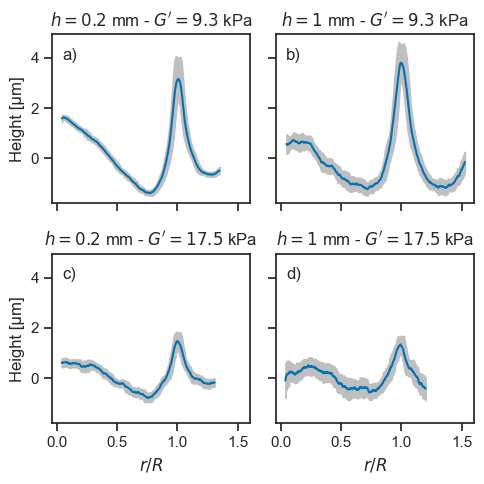

In [23]:
fig,axes = plt.subplots(2,2, figsize=(5,5), sharey=True, sharex=True)
subplot_labels = ["a)","b)","c)","d)"]
title_dict = {"80_S_thin":"$h=0.2$ mm - $G'=9.3$ kPa", "80_S_thick":"$h=1$ mm - $G'=9.3$ kPa", "80_H_thin":"$h=0.2$ mm - $G'=17.5$ kPa", "80_H_thick":"$h=1$ mm - $G'=17.5$ kPa"}
for i, key in enumerate(order):
    df = df_dict[key]
    df["scaled_y"] = df["rolling_y"] / df["rolling_y"].max()
    df["scaled_y_stdev"] = df["rolling_y_stdev"] / df["rolling_y"].max()
    ax = axes[i//2, i%2]
        
    
    ax.fill_between(df["norm_x"], df["rolling_y"]-df["rolling_y_stdev"], df["rolling_y"]+df["rolling_y_stdev"], color=(0.75,0.75,0.75,1))
    sns.lineplot(data=df, x="norm_x", y="rolling_y", ax=ax)
    # sns.lineplot(data=df, x="norm_x", y="scaled_y", ax=ax)
    # ax.fill_between(df["norm_x"], df["scaled_y"]-df["scaled_y_stdev"], df["scaled_y"]+df["scaled_y_stdev"], alpha=0.2,color="k")
    # sns.lineplot(data=df, x="norm_x", y="fit_y", ax=ax)
    ax.set_title(title_dict[key])
    ax.set_xlabel("$r/R$")
    ax.set_ylabel("Height [µm]")
    # ax.set_ylabel("$y/y_{max}$")

    ax.text(0.05, 0.85, subplot_labels[i], transform=ax.transAxes)
plt.tight_layout()
fig.savefig(plot_out_dir / "ridge_fit.pdf", bbox_inches="tight")
fig.savefig(plot_out_dir / "ridge_fit.png", bbox_inches="tight")
fig.savefig(plot_out_dir / "ridge_fit.svg", bbox_inches="tight")

### 2d ridge with model from actual values

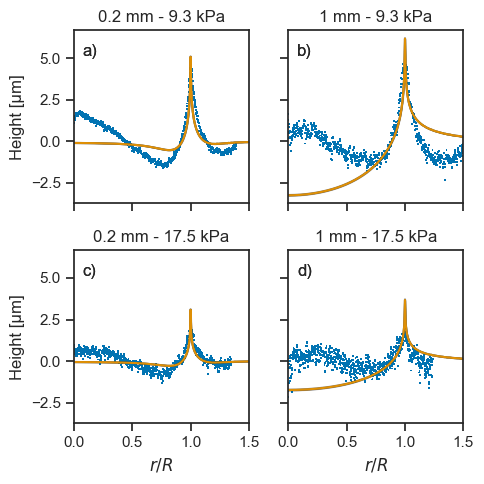

In [24]:
fig,axes = plt.subplots(2,2, figsize=(5,5), sharey=True, sharex=True)
subplot_labels = ["a)","b)","c)","d)"]
title_dict = {"80_S_thin":"0.2 mm - 9.3 kPa", "80_S_thick":"1 mm - 9.3 kPa", "80_H_thin":"0.2 mm - 17.5 kPa", "80_H_thick":"1 mm - 17.5 kPa"}
real_x = np.linspace(0,1.5e-3,250)
for i, key in enumerate(order):
    df = df_dict[key]
    df["scaled_y"] = df["rolling_y"] / df["rolling_y"].max()
    df["scaled_y_stdev"] = df["rolling_y_stdev"] / df["rolling_y"].max()
    ax = axes[i//2, i%2]
    model = model_dict[key]
    ax = axes[i//2, i%2]
    palette = sns.color_palette()
    fit_y_max = 1e6*style_exact(real_x, model.gamma, 1e-3, model.popt[0], initial_params_actual["E_lookup_max"][key[0:4]], model.popt[2])
    fit_y_min = 1e6*style_exact(real_x, model.gamma, 1e-3, model.popt[0], initial_params_actual["E_lookup_min"][key[0:4]], model.popt[2])
    fit_y_th = 1e6*style_exact(real_x, model.gamma, 1e-3, model.popt[0], initial_params_actual["E_lookup"][key[0:4]], model.popt[2])

    # x = real_x / model.radius
    x = real_x*1e3
    y_max = fit_y_th.max()
    fit_y_th = fit_y_th#/y_max
    fit_y_min = fit_y_min#/y_max
    fit_y_max = fit_y_max#/y_max

    # sns.lineplot(data=df, x="x", y="fit_y", ax=ax,color=palette[1])
    sns.lineplot(x=x, y=fit_y_max, ax=ax, color="k", alpha=0.5)
    sns.lineplot(x=x, y=fit_y_min, ax=ax, color="k", alpha=0.5)
    ax.fill_between(x, fit_y_min, fit_y_max, alpha=0.2,color="k")
    sns.lineplot(x=x, y=fit_y_th, ax=ax,color=palette[1])
    ax.set_title(title_dict[key])
    ax.set_xlabel("$r/R$")
    # ax.set_ylabel("Height [µm]")
    ax.set_ylabel("$y/y_{max}$")

    ax.text(0.05, 0.85, subplot_labels[i], transform=ax.transAxes)
        
    sns.scatterplot(data=df, x="norm_x", y="y", ax=ax, marker=",", edgecolors="none", s=2, color=palette[0])
    # ax.fill_between(df["norm_x"], df["rolling_y"]-df["rolling_y_stdev"], df["rolling_y"]+df["rolling_y_stdev"], alpha=0.2,color="k")
    # sns.lineplot(data=df, x="norm_x", y="scaled_y", ax=ax)
    # ax.fill_between(df["norm_x"], df["scaled_y"]-df["scaled_y_stdev"], df["scaled_y"]+df["scaled_y_stdev"], alpha=0.2,color="k")
    # sns.lineplot(data=df, x="norm_x", y="fit_y", ax=ax)
    ax.set_title(title_dict[key])
    ax.set_xlabel("$r/R$")
    ax.set_ylabel("Height [µm]")
    # ax.set_ylabel("$y/y_{max}$")

    ax.text(0.05, 0.85, subplot_labels[i], transform=ax.transAxes)
    ax.set_xlim(0,1.5)
plt.tight_layout()
fig.savefig(plot_out_dir / "ridge_fit_sc_real.svg", bbox_inches="tight")
fig.savefig(plot_out_dir / "ridge_fit_sc_real.png", bbox_inches="tight")

### 2d ridge with fitted models

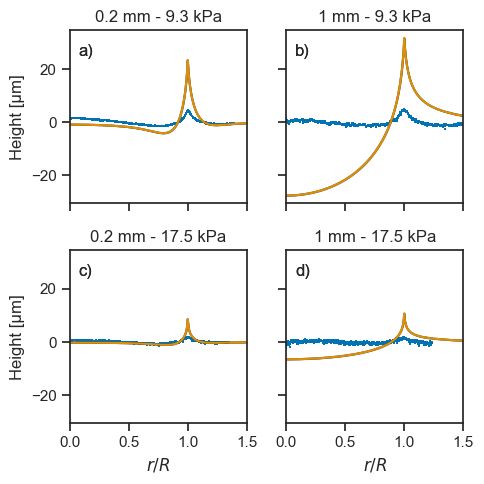

In [25]:
fig,axes = plt.subplots(2,2, figsize=(5,5), sharey=True, sharex=True)
subplot_labels = ["a)","b)","c)","d)"]
title_dict = {"80_S_thin":"0.2 mm - 9.3 kPa", "80_S_thick":"1 mm - 9.3 kPa", "80_H_thin":"0.2 mm - 17.5 kPa", "80_H_thick":"1 mm - 17.5 kPa"}
real_x = np.linspace(0,1.5e-3,250)
for i, key in enumerate(order):
    df = df_dict[key]
    df["scaled_y"] = df["rolling_y"] / df["rolling_y"].max()
    df["scaled_y_stdev"] = df["rolling_y_stdev"] / df["rolling_y"].max()
    ax = axes[i//2, i%2]
    model = model_dict[key]
    ax = axes[i//2, i%2]
    palette = sns.color_palette()
    fit_y_max = 1e6*style_exact(real_x, model.gamma, 1e-3, *model.popt)
    fit_y_min = 1e6*style_exact(real_x, model.gamma, 1e-3, *model.popt)
    fit_y_th = 1e6*style_exact(real_x, model.gamma, 1e-3, *model.popt)

    # x = real_x / model.radius
    x = real_x*1e3
    y_max = fit_y_th.max()
    fit_y_th = fit_y_th#/y_max
    fit_y_min = fit_y_min#/y_max
    fit_y_max = fit_y_max#/y_max

    # sns.lineplot(data=df, x="x", y="fit_y", ax=ax,color=palette[1])
    sns.lineplot(x=x, y=fit_y_max, ax=ax, color="k", alpha=0.5)
    sns.lineplot(x=x, y=fit_y_min, ax=ax, color="k", alpha=0.5)
    ax.fill_between(x, fit_y_min, fit_y_max, alpha=0.2,color="k")
    sns.lineplot(x=x, y=fit_y_th, ax=ax,color=palette[1])
    ax.set_title(title_dict[key])
    ax.set_xlabel("$r/R$")
    # ax.set_ylabel("Height [µm]")
    ax.set_ylabel("$y/y_{max}$")

    ax.text(0.05, 0.85, subplot_labels[i], transform=ax.transAxes)
        
    sns.scatterplot(data=df, x="norm_x", y="y", ax=ax, marker=",",edgecolors="none", s=2, color=palette[0])
    # ax.fill_between(df["norm_x"], df["rolling_y"]-df["rolling_y_stdev"], df["rolling_y"]+df["rolling_y_stdev"], alpha=0.2,color="k")
    # sns.lineplot(data=df, x="norm_x", y="scaled_y", ax=ax)
    # ax.fill_between(df["norm_x"], df["scaled_y"]-df["scaled_y_stdev"], df["scaled_y"]+df["scaled_y_stdev"], alpha=0.2,color="k")
    # sns.lineplot(data=df, x="norm_x", y="fit_y", ax=ax)
    ax.set_title(title_dict[key])
    ax.set_xlabel("$r/R$")
    ax.set_ylabel("Height [µm]")
    # ax.set_ylabel("$y/y_{max}$")

    ax.text(0.05, 0.85, subplot_labels[i], transform=ax.transAxes)
    ax.set_xlim(0,1.5)
plt.tight_layout()
fig.savefig(plot_out_dir / "ridge_fit_sc_fit.svg", bbox_inches="tight")
fig.savefig(plot_out_dir / "ridge_fit_sc_fit.png", bbox_inches="tight")

### 3d plotly

In [ ]:
%%script false --no-raise-error

from skimage.filters import gaussian
from skimage.transform import rescale
from plotly import graph_objects as go

for file in eval_dir.rglob("*.pkl"):
    # if not "80_S" in str(file):
    #     continue
        
    with open(file, "rb") as f:
        yc,xc,r,r2,image,pixelscale,rim_binarized,fits,ridge = pickle.load(f)

    image = gaussian(image, sigma=20)
    image = rescale(image, 1/4, anti_aliasing=True)
    image *= 1000

    y = (np.arange(image.shape[0])) * pixelscale[0] * 1000 * 4
    x = (np.arange(image.shape[1]))* pixelscale[1]  * 1000 * 4
    # x_grid, y_grid = np.meshgrid(x,y)
    # fig = plt.figure(figsize=(20, 4))
    # ax = fig.add_subplot(1, 1, 1, projection="3d")
    # ax.plot_surface(x_grid, y_grid, image, cmap="seismic", linewidth=0, antialiased=True)
    # ax.set_ylim(ax.get_xlim())
    # ax.set_zlim(-0.1,0.1)
    # ax.set_xlabel("\nx [mm]")
    # ax.set_ylabel("\ny [mm]")
    # ax.set_zlabel("\nHeight [mm]")
    # # ax.zaxis.labelpad=30
    # # ax.set_box_aspect(aspect=None, zoom=0.8)
    # ax.autoscale_view()
    # # fig.suptitle(file.stem)
    # fig.tight_layout()
    # fig.savefig(plot_out_dir / "80_S_3D.pdf", bbox_inches="tight")

    fig = go.Figure(data=[go.Surface(z=image, x=x, y=y, colorbar=dict(len=1, thickness=10, orientation = "h", yanchor="bottom", y=0), 
                                     colorbar_title="Height [mm]", colorbar_title_side="top", colorscale="icefire")])#"balance", "haline", "ice", "rdylbu_r", "spectral_r", "jet"#, cmin=-0.01, cmax=0.01, showscale=False,)])

    fig.update_layout(#title="80_S", autosize=True,
                        width=650, height=600,
                        margin=dict(l=0, r=0, b=0, t=30),
                        scene=dict(aspectmode="manual", aspectratio=dict(x=1, y=1, z=0.1),
                                    xaxis_title="x [mm]",
                                    yaxis_title="y [mm]",
                                    # zaxis_title="Height [mm]",
                                    zaxis = dict(nticks=2, range=[-0.01,0.04], showticklabels=False, showaxeslabels=False)),
                        font_size=16,
                        font_color="black",
                        font_family="sans-serif",
    )

    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=-.2),
        eye=dict(x=-1, y=-1, z=1)
    )

    fig.update_layout(scene_camera=camera)
    
    fig.show()
    # fig.write_html(str(plot_out_dir / "80_S_3D.html"))
    # fig.write_image(str(plot_out_dir / "80_S_3D.pdf"),scale=4)
    # fig.write_image(str(plot_out_dir / "80_S_3D.png"),scale=4)

In [ ]:
from skimage.filters import gaussian
from skimage.transform import rescale
from plotly import graph_objects as go
from plotly.subplots import make_subplots
subplot_labels = ["a)","b)","c)","d)"]
title_dict = {"80_S_thin":"$h=0.2 \\text{\\,mm - }G'=9.3\\text{\\,kPa}$", "80_S_thick":"$h=1 \\text{\\,mm - }G'=9.3\\text{\\,kPa}$", 
              "80_H_thin":"$h=0.2 \\text{\\,mm - }G'=17.5\\text{\\,kPa}$", "80_H_thick":"$h=1 \\text{\\,mm - }G'=17.5\\text{\\,kPa}$"}
images = {}
rescale_factor = 8
for file in eval_dir.rglob("*.pkl"):
    # if not "80_S" in str(file):
    #     continue
    Fe, G, vol, th, *_ = Path(file).stem.split("_")    
    with open(file, "rb") as f:
        yc,xc,r,r2,image,pixelscale,rim_binarized,fits,ridge = pickle.load(f)

    image = gaussian(image, sigma=20)
    image = rescale(image, 1/rescale_factor, anti_aliasing=True)
    image *= 1000

    y = (np.arange(image.shape[0])) * pixelscale[0] * 1000 * rescale_factor
    x = (np.arange(image.shape[1]))* pixelscale[1]  * 1000 * rescale_factor
    images[f"{Fe}_{G}_{th}"] = dict(z=image, x=x, y=y)


fig = make_subplots(
    rows=2, cols=2, shared_xaxes=True, shared_yaxes=True, vertical_spacing=0, horizontal_spacing=0, 
    specs=[[{'type': 'surface'}, {'type': 'surface'}],
            [{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=[title_dict[key] for key in order]
)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thin"]),
                row=1, col=1)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thick"]),
                row=1, col=2)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_H_thin"]),
                row=2, col=1)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_H_thick"]),
                row=2, col=2)

fig.update_layout(#title="80_S", autosize=True,
                    width=650, height=600,
                    margin=dict(l=0, r=0, b=0, t=0),
                    font_size=14,
                    font_color="black",
                    font_family="sans-serif",
)

fig.update_coloraxes(colorscale='icefire', colorbar=dict(len=1, thickness=10, orientation = "h", yanchor="bottom", y=0), 
                        colorbar_title="Height [mm]", 
                        colorbar_title_side="top", cmax=0.005, cmin=-0.005)



fig["layout"]["annotations"][0]["y"]=0.9
fig["layout"]["annotations"][1]["y"]=0.9
fig["layout"]["annotations"][2]["y"]=0.5
fig["layout"]["annotations"][3]["y"]=0.5
#location of the annotations
anno_x = [0.05, 0.55]
anno_y = [0.8, 0.45]
annotations = list()
for i, label in enumerate(subplot_labels):
    fig.add_annotation(text=label, x=anno_x[i % 2], y=anno_y[i // 2], xref='paper', yref='paper', showarrow=False, font=dict(size=18))
# anno_x = [0, 1]
# anno_y = [0.9, 0.5]
# for i, (key,title) in enumerate(title_dict.items()):
#     # annotations.append(dict(text=title_dict[key], showarrow=False, x=0.5, y=1, xref=f'x{i+1 if i>0 else ""} domain', yref=f'y{i+1 if i>0 else ""} domain', font=dict(size=24)))
#     # fig.add_annotation(dict(
#     #     text=title, 
#     #     showarrow=False, x=anno_x[i % 2], y=anno_y[i // 2], xref='paper', yref='paper',
#     #     font=dict(size=20)))
#     fig.add_annotation(dict(
#         text=title, 
#         showarrow=False, x=.5, y=1, xref='x domain', yref='y domain',
#         font=dict(size=20)))


camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.2, y=-1.2, z=1.2)
)
camera2 = dict(
    up=dict(x=0, y=0, z=.5),
    center=dict(x=0, y=0, z=-.5),
    eye=dict(x=-1.2, y=-1.2, z=1.2)
)

# fig.update_layout(scene_camera=camera)
fig.layout.scene1.camera = camera
fig.layout.scene2.camera = camera
fig.layout.scene3.camera = camera2
fig.layout.scene4.camera = camera2

scene=dict(aspectmode="manual", aspectratio=dict(x=1, y=1, z=0.2),
            xaxis_title="x [mm]",
            yaxis_title="y [mm]",
            # zaxis_title="Height [mm]",
            zaxis = dict(nticks=2,  showticklabels=False, showaxeslabels=False))

fig.update_layout(scene1=scene, scene2=scene, scene3=scene, scene4=scene)

fig.show()
# fig.write_html(str(plot_out_dir / "80_S_3D.html"))
# fig.write_image(str(plot_out_dir / "80_S_3D.pdf"),scale=4)
# fig.write_image(str(plot_out_dir / "80_S_3D.png"),scale=4)

## Theoreticl plots

In [ ]:
fig,axes = plt.subplots(2,2, figsize=(5,5), sharey=True, sharex=True)
subplot_labels = ["a)","b)","c)","d)"]
title_dict = {"80_S_thin":"$h=0.2$ mm - $G'=9.3$ kPa", "80_S_thick":"$h=1$ mm - $G'=9.3$ kPa", "80_H_thin":"$h=0.2$ mm - $G'=17.5$ kPa", "80_H_thick":"$h=1$ mm - $G'=17.5$ kPa"}
real_x = np.linspace(0,1.5e-3,250)
for i, key in enumerate(order):
    df = df_dict[key]
    model = model_dict[key]
    ax = axes[i//2, i%2]
    palette = sns.color_palette()
    fit_y_max = 1e6*style_exact(real_x, model.gamma, 1e-3, model.popt[0], initial_params_actual["E_lookup_max"][key[0:4]], model.popt[2])
    fit_y_min = 1e6*style_exact(real_x, model.gamma, 1e-3, model.popt[0], initial_params_actual["E_lookup_min"][key[0:4]], model.popt[2])
    fit_y_th = 1e6*style_exact(real_x, model.gamma, 1e-3, model.popt[0], initial_params_actual["E_lookup"][key[0:4]], model.popt[2])

    # x = real_x / model.radius
    x = real_x*1e3
    y_max = fit_y_th.max()
    fit_y_th = fit_y_th#/y_max
    fit_y_min = fit_y_min#/y_max
    fit_y_max = fit_y_max#/y_max
    # ax.fill_between(df["norm_x"], df["rolling_y"]-df["rolling_y_stdev"], df["rolling_y"]+df["rolling_y_stdev"], color=(0.75,0.75,0.75,1))
    sns.lineplot(data=df, x="norm_x", y="rolling_y", ax=ax, alpha=0.3)

    # sns.lineplot(data=df, x="x", y="fit_y", ax=ax,color=palette[1])
    sns.lineplot(x=x, y=fit_y_max, ax=ax, color="k", alpha=0.5)
    sns.lineplot(x=x, y=fit_y_min, ax=ax, color="k", alpha=0.5)
    ax.fill_between(x, fit_y_min, fit_y_max, alpha=0.2,color="k")
    sns.lineplot(x=x, y=fit_y_th, ax=ax,color=palette[1])
    ax.set_title(title_dict[key])
    ax.set_xlabel("$r/R$")
    ax.set_ylabel("Height [µm]")
    # ax.set_ylabel("$y/y_{max}$")

    ax.text(0.05, 0.85, subplot_labels[i], transform=ax.transAxes)
plt.tight_layout()
plt.savefig(plot_out_dir / "theory_plots.pdf", bbox_inches="tight")

In [ ]:
from data_types import RidgeFit, RidgeFitMethod
from skimage.transform import rescale
# Extract ridge from images and store as csv
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
from ridge_extractor import extract_ridge_from_image
from ridge_profile_fit import fit_profile
from skimage.draw import circle_perimeter
# import numba as nb
from ridge_models import style_exact, style_ld_ts, shanahan, limat_symmetric
# from scipy.signal import savgol_filter
import asyncio

source_dir = Path(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80")
# R= 0.0002
upsilon = 0.06 # from 10.1002/marc.202000360
gamma = 0.072 # from https://en.wikipedia.org/wiki/Surface_tension

initial_params_actual = {\
    "h" : {"thick": 0.001, "thin": 0.0002},
    "E_lookup" : {"70_S":4863*3,"70_H":10705*3,"80_S":14928*3,"80_H":30417*3},
    "upsilon" : (0.059+0.016)/2, # from Park et al
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
    "gamma_s": 0.021, # https://doi.org/10.1038/ncomms5369, https://doi.org/10.1103/PhysRevLett.109.038001
    "theta": 100
}

initial_params = {\
    "h" : {"thick": 0.001, "thin": 0.0002},
    "E_lookup" : {"70_S":240,"70_H":1200,"80_S":3200,"80_H":14000},
    "upsilon" : (0.059+0.016)/2, # from https://doi.org/10.1002/marc.202000360, https://doi.org/10.1038/ncomms5369, https://iopscience.iop.org/article/10.1088/0370-1298/63/5/302/pdf
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
    "gamma_s": 0.021, # https://doi.org/10.1038/ncomms5369, https://doi.org/10.1103/PhysRevLett.109.038001
    "theta": 100
}


# https://stackoverflow.com/a/59385935/9173710

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

def _fit_calc(radial_coord, gamma, radius, popt, downscale_factor):
    radial_resized = rescale(radial_coord, downscale_factor, anti_aliasing=False)
    img_calc = np.zeros_like(radial_resized)

    for i in np.ndindex(img_calc.shape[0]):
        img_calc[i,:] = style_exact(radial_resized[i,:], gamma, radius, *popt)
    return img_calc

@background
def compare_fit_with_original(file):
    try:
        downscale_factor = 0.1
        ridge, image, circ_params, rim_binarized, r2, pixelscale = \
                extract_ridge_from_image(file, robust=True, threshold=0.55, use_kmeans=False, butterworth_cutoff=0.01, gamma_correction=3)
        yc,xc,r = circ_params
        # rolling average
        x_r, y_r = ridge
        # y_r = np.convolve(y_r, np.ones(10), 'same') / 10
        # y_r = savgol_filter(y_r, 500, 2)
        print(f"{file.stem} Center: ({yc},{xc}) Radius: {r} R2: {r2}")
        df = pd.DataFrame({"x":x_r,"y":y_r})
        df.to_csv(file.with_suffix(".rdg"), sep=";")

        fits: dict[str, RidgeFit] = fit_profile(file.with_suffix(".rdg"), **initial_params)

        # ycs,xcs = yc*pixelscale[1], xc*pixelscale[0]
        # x_values = np.arange(image.shape[1])*pixelscale[0] - xcs
        # y_values = np.arange(image.shape[0])*pixelscale[1] - ycs

        # # radial_coord = np.zeros((image.shape[0], image.shape[1]))

        # x_grid,y_grid = np.meshgrid(x_values, y_values)
        # radial_coord = np.sqrt((x_grid)**2 + (y_grid)**2).astype(np.float32)
        # # angle_coord = np.arctan2(y_grid, x_grid)
        # Fe, G, vol, th, *_ = Path(file).stem.split("_")

        # img_calc = _fit_calc(radial_coord, fits["style"].gamma, fits["style"].radius, fits["style"].popt, downscale_factor=downscale_factor)
        # # img_expect = _fit_calc(radial_coord, fits["style"].gamma, fits["style"].radius, (initial_params_actual["upsilon"],initial_params_actual["E_lookup"][f"{Fe}_{G}"], initial_params_actual["h"][th]), downscale_factor=downscale_factor)
        # # img_calc = style_exact(radial_coord, fits["style"].gamma, r, *fits["style"].popt)

        pickle.dump((yc,xc,r,r2,image,pixelscale,rim_binarized,fits,ridge), open(file.with_suffix(".pkl"), "wb"))

    except Exception as e:
            print(e)
            print(file)
            # raise

        # raise

# glb = source_dir.rglob("*_f.ome.tif")

futures = list()

sem = asyncio.Semaphore(4)
for file in glb:
    # compare_fit_with_original(file, pandas_data)
    async with sem:
        futures.append(compare_fit_with_original(file))



res = await asyncio.gather(*futures)
          
# asyncio.get_event_loop().run_until_complete(asyncio.gather(*futures))
# asyncio.get_event_loop().close()

## Effects of variables

In [ ]:
fig,axes = plt.subplots(1,3, figsize=(10,3.33), sharey=True, sharex=True)
subplot_labels = ["a)","b)","c)"]
x = np.linspace(0.0005, 0.0015, 250)
norm_x = x / 0.001
for e in [2000, 5000, 10000, 20000, 50000]:
    axes[0].set_title("E")
    fit_y = style_exact(x, 0.072, 1e-3, 39e-3, e, 1e-3)*1e6
    sns.lineplot(x=norm_x, y=fit_y, ax=axes[0], label=f"{e} Pa")
    axes[0].set_xlabel("r/R")
    axes[0].set_ylabel("Height [µm]")
axes[0].text(0.05, 0.9, subplot_labels[0], transform=axes[0].transAxes)

for ups in np.linspace(0.001,0.1,5):
    axes[1].set_title("Upsilon")
    fit_y = style_exact(x, 0.072, 1e-3, ups, 5000, 0.051e-3)*1e6
    sns.lineplot(x=norm_x, y=fit_y, ax=axes[1], label=f"{ups*1000:.0f} mN/m")
    axes[1].set_xlabel("r/R")
    axes[1].set_ylabel("Height [µm]")
    axes[1].set_xlim(0.9,1.3)
axes[1].text(0.05, 0.9, subplot_labels[1], transform=axes[1].transAxes)

for h in np.linspace(0.00005,0.0015,5):
    axes[2].set_title("h")
    fit_y = style_exact(x, 0.072, 1e-3, 39e-3, 9000, h)*1e6
    sns.lineplot(x=norm_x, y=fit_y, ax=axes[2], label=f"{h*1000:.1f} mm")
    axes[2].set_xlabel("r/R")
    axes[2].set_ylabel("Height [µm]")
axes[2].text(0.05, 0.9, subplot_labels[2], transform=axes[2].transAxes)

plt.tight_layout()
plt.savefig(plot_out_dir / "variable_effects.pdf", bbox_inches="tight")